In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, jacrev, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid, relu

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(12345)

In [2]:
# generate data using ground truth value for a 
a_true = -.5
b_true = 1.
n = 8
f = lambda x: a_true * x + b_true * x**2

# precision of prior
alpha = 1.

# precision of noise
s = a_true/10.
beta = 1./s**2

# generate data 
x = np.linspace(0., 1., n)[1:]
t = f(x) + s * np.random.randn(n-1) 
# t[0] = 0.

# analytical posterior 
basis = lambda x: jnp.array([x, x**2])
Phi = vmap(basis)(x)

# Hessian 
Sinv = alpha*np.eye(Phi.shape[1]) + beta * Phi.T @ Phi 
# Covariance
S = np.linalg.inv(Sinv)
# Mean 
m = beta * S @ Phi.T @ t

In [3]:
# posterior predictive distribution 
x_eval = np.linspace(0, 1., 100)
Phi = vmap(basis)(x_eval)
t_hat_true = Phi@m
s_hat_true = np.sqrt(np.einsum('ni,ij,nj->n', Phi, S, Phi))

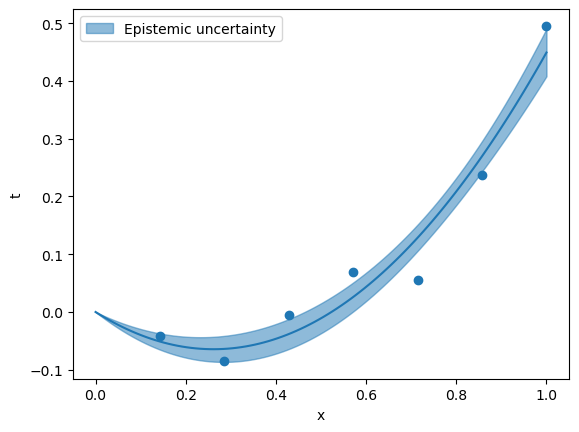

In [4]:
plt.scatter(x, t)
plt.plot(x_eval, t_hat_true)
plt.fill_between(x_eval, t_hat_true-s_hat_true, t_hat_true+s_hat_true, alpha=.5, color='C0', 
                 label='Epistemic uncertainty')
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("t")
# plt.ylim([-1.1, 1.1])
plt.show()

In [5]:
# goal is to use a neural network to map Gaussian noise to samples from posterior parameter distribution

In [6]:
# define model that takes in unknown parameters (latent variables)
@jit
def model(x, z):
    
    a, b = z
    
    return a*x + b*x**2

# gradient of model w.r.t. parameters
grad_model = jit(jacfwd(model, 1))

# problem dimension
d = 2

# hidden dimension of NN (weird things happen when h < d)
h = 2

# determine shapes of weights/biases = [Wih, bih, Who, bho]
shapes = [[h, d], [h], [d, h], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape) > 1:
        stdv = 2. / np.sqrt(2 * shape[-1])
        # lmbda[k1:k2] = np.log2(np.random.uniform(0., stdv, k2 - k1, ))
        lmbda[k1:k2] = np.random.uniform(0., stdv, k2 - k1, )
    else:
        lmbda[k1:k2] = np.random.randn(k2 - k1, ) / np.sqrt(2.)
    
# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]


@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    W1, b1, W2, b2 = reshape(lmbda)

    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', W1, y) + b1)

    # output
    z = jnp.einsum('ij,...j->...i', W2, h) + b2

    return z

# gradient of nn output w.r.t. parameters
grad_nn = jit(jacfwd(nn, 1))
    
# gradient of nn output w.r.t. parameters
jac_nn = jit(jacfwd(nn, 0))

# log of absolute value of determinant of Jacobian of neural network
@jit
def log_det(yi, lmbda):
    # return jnp.log(jnp.abs(jnp.linalg.det(jac_nn(yi, lmbda))))
    return jnp.sum(jnp.log(jnp.abs(jnp.linalg.eigvals(jac_nn(yi, lmbda)))))

# gradient of log abs det w.r.t. neural network parameters
grad_log_det = jit(jacrev(log_det, 1))

# evaluate log_det in batches
batch_log_det = jit(vmap(log_det, (0, None)))

# gradient of entropy of approximating distribution w.r.t. lmbda
batch_grad_log_det = jit(jacrev(batch_log_det, 1))

# evaluate log (likelihood * prior)
@jit
def log_posterior(y, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    # likelihood
    lp = beta * jnp.sum((t - model(x, z))**2) / 2. 
    # prior
    lp += alpha * jnp.sum(z**2) / 2. 
    return lp

# gradient of log posterior
grad_log_posterior = jit(jacrev(log_posterior, 1))

# eval log posterior in batches 
batch_log_posterior = jit(vmap(log_posterior, (0, None)))

# gradient of log posterior
batch_grad_log_posterior = jit(jacrev(batch_log_posterior, 1))

print(f"number of parameters in nn: {n_params}")

number of parameters in nn: 12


In [7]:
y = np.random.randn(d)

Future steps toward improving tractability as problems get more complicated will be implementation of neural network architectures that the simplify the determinant computation. Examples include planar flow and autoregressive architectures.  

In [8]:
# ELBO cost function 
def elbo(lmbda, n_sample=10):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # evaluate model fitness 
    ELBO = np.mean(batch_log_posterior(y, lmbda), 0)
    ELBO -= np.mean(batch_log_det(y, lmbda), 0)
    
    return ELBO

# gradient of ELBO cost function
def grad_elbo(lmbda, n_sample=10):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # gradient 
    grad_ELBO = np.mean(batch_grad_log_posterior(y, lmbda), 0)
    grad_ELBO -= np.mean(batch_grad_log_det(y, lmbda), 0)
    
    return grad_ELBO

In [9]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iterations=4000, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        
        if t%10==0:
            print("ELBO: {:.3f}".format(elbo(params, n_sample=10)))

        gradient = np.nan_to_num(grad_f(params))
        
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [10]:
# optimize nn parameters
lmbda = adam_optimizer(elbo, grad_elbo, lmbda)

ELBO: 1611.050
ELBO: 694.456
ELBO: 632.469
ELBO: 215.947
ELBO: 242.627
ELBO: 274.524
ELBO: 105.237
ELBO: 50.124
ELBO: 24.795
ELBO: 19.185
ELBO: 20.097
ELBO: 18.930
ELBO: 15.904
ELBO: 16.980
ELBO: 15.598
ELBO: 12.336
ELBO: 12.343
ELBO: 11.931
ELBO: 11.901
ELBO: 11.566
ELBO: 11.871
ELBO: 11.662
ELBO: 11.958
ELBO: 12.094
ELBO: 11.713
ELBO: 11.445
ELBO: 11.354
ELBO: 11.283
ELBO: 11.209
ELBO: 10.898
ELBO: 11.287
ELBO: 11.214
ELBO: 11.176
ELBO: 11.284
ELBO: 11.236
ELBO: 11.424
ELBO: 11.158
ELBO: 11.076
ELBO: 11.721
ELBO: 12.472
ELBO: 11.515
ELBO: 11.033
ELBO: 12.696
ELBO: 11.063
ELBO: 10.867
ELBO: 11.184
ELBO: 10.680
ELBO: 11.846
ELBO: 10.947
ELBO: 11.226
ELBO: 11.877
ELBO: 12.162
ELBO: 11.089
ELBO: 11.021
ELBO: 10.473
ELBO: 10.667
ELBO: 10.959
ELBO: 11.267
ELBO: 11.088
ELBO: 11.049
ELBO: 13.251
ELBO: 11.056
ELBO: 10.846
ELBO: 10.579
ELBO: 10.896
ELBO: 10.459
ELBO: 11.468
ELBO: 11.067
ELBO: 13.766
ELBO: 10.814
ELBO: 12.067
ELBO: 11.189
ELBO: 10.450
ELBO: 11.141
ELBO: 10.942
ELBO: 10.735
ELBO

In [11]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(2000, d)
z = nn(y, lmbda)

In [12]:
np.cov(np.array(z).T)

array([[ 0.01273097, -0.01510803],
       [-0.01510803,  0.01926564]])

In [13]:
S

array([[ 0.01385445, -0.01623946],
       [-0.01623946,  0.02031709]], dtype=float32)

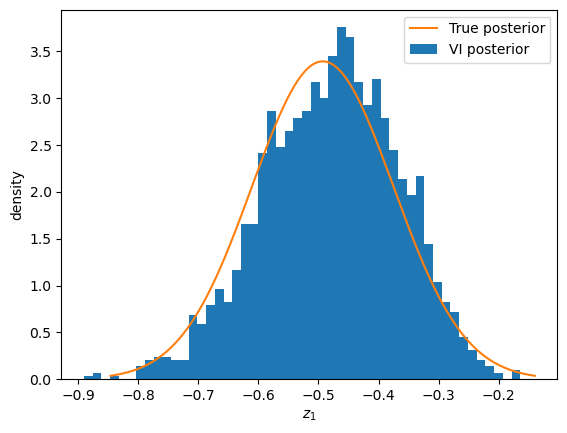

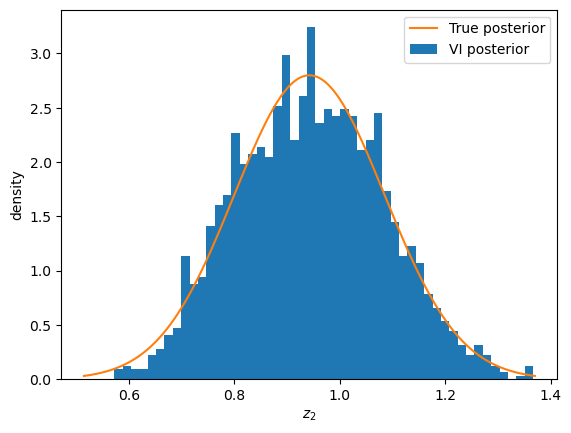

In [14]:
for i, (mean, variance) in enumerate(zip(m, np.diag(S))):

    # Generate data points for x-axis
    x_vals = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), 1000)

    # Calculate the corresponding probability density function (PDF) values
    pdf_values = norm.pdf(x_vals, mean, np.sqrt(variance))
    plt.plot(x_vals, pdf_values, c='C1', label='True posterior')
    
    # plot NN posterior 
    plt.hist(np.array(z[:, i]), color='C0', bins=50, density=True, label='VI posterior')
    
    plt.xlabel(f"$z_{i+1}$")
    plt.ylabel("density")
    plt.legend()
    plt.show()

In [15]:
# plot posterior predictive 
t_samples = vmap(model, (None, 0))(x_eval, z)
t_hat = np.mean(t_samples, 0)
s_hat = np.std(t_samples, 0)

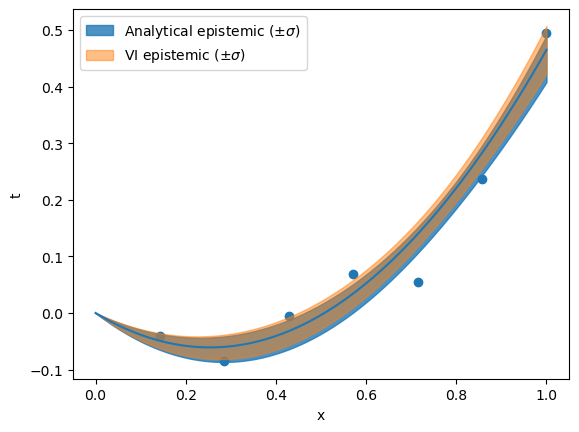

In [16]:
plt.scatter(x, t)
plt.plot(x_eval, t_hat)
plt.fill_between(x_eval, t_hat_true-s_hat_true, t_hat_true+s_hat_true, alpha=.8, color='C0', 
                 label='Analytical epistemic ($\pm \sigma$)')
plt.fill_between(x_eval, t_hat-s_hat, t_hat+s_hat, alpha=.5, color='C1', label='VI epistemic ($\pm \sigma$)')
plt.xlabel("x")
plt.ylabel("t")
plt.legend(loc='upper left')
# plt.ylim([-1, 1])
# plt.savefig("figures/linear_regression.png")
plt.show()